In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import glob
import netCDF4 as nc
from torchvision import transforms

scale_factor=1.3
def load_data_from_directory(directory,scale_factor=1.0):
    file_paths = glob.glob(f'{directory}/*.nc')
    all_data = []
    all_masks = []

    for file_path in file_paths:
        dataset = nc.Dataset(file_path, 'r')
        file_name = os.path.basename(file_path)
        prefix = file_name.split('.')[0]
        data_var = dataset.variables[prefix][:]  # Adjust if needed
        mask_var = dataset.variables['mask'][:]
        mask_var = np.expand_dims(mask_var, axis=0)
        missing_value = dataset.variables[prefix]._FillValue

        # Generate mask and handle missing values
        mask = (mask_var == 1).astype(np.float32)
        data_var[data_var == missing_value] = 0
        data_var = np.nan_to_num(data_var, nan=0.0)

        # M1:Apply Z-score standardization:
        mean = np.mean(data_var)
        std = np.std(data_var)
        # data_var = (data_var - mean) / (std + 1e-8)  # Add a small value to prevent division by zero
        # M2:Apply scaling factor to the data
        data_var *= scale_factor
        all_data.append(data_var)
        all_masks.append(mask)

        dataset.close()

    # Combine all bands along the channel dimension
    all_data = np.concatenate(all_data, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)

    return all_data, all_masks , mean ,std

class OceanDataset(Dataset):
    def __init__(self, data, mask, transform=None, mask_transform=None,use_random_mask=False,mask_ratio=0.0):
        self.data = data
        self.mask = mask
        self.transform = transform
        self.mask_transform = mask_transform
        self.use_random_mask = use_random_mask
        self.mask_ratio = mask_ratio  # 添加掩码比例

    def __len__(self):
        # Since each sample is a 24-day sequence
        return self.data.shape[0] // 24

    def __getitem__(self, idx):
        start_idx = idx * 24
        end_idx = start_idx + 24
        data_sample = self.data[start_idx:end_idx]
        mask_sample = self.mask[idx]

        if self.transform:
            # data_sample = np.expand_dims(data_sample, axis=3)## channel=1
            data_sample = np.transpose(data_sample, (1, 2, 0))
            data_sample = self.transform(data_sample)
        if self.mask_transform:
            # mask_sample = np.expand_dims(mask_sample, axis=3)## channel=1
            mask_sample = self.mask_transform(mask_sample)
        # 生成基于 data_sample 的掩码
        data_based_mask = (data_sample == 0).float()
        if self.use_random_mask:
            # 随机生成掩码，掩码比例为 self.mask_ratio,当随机数小于 self.mask_ratio 时，对应位置为 True，否则为 False。这个布尔张量就相当于一个随机掩码，True 表示需要掩码的地方，False 表示不掩码的地方
            random_mask = torch.rand_like(mask_sample) < self.mask_ratio
            # 更新原掩码，将随机掩码位置设为1
            mask_sample = torch.max(mask_sample, random_mask.float())
        # 最终掩码同时包含随机掩码、data_sample为0的位置以及原始掩码
        mask_sample = torch.max(mask_sample, data_based_mask)
        meta_data = (data_sample != 0).float()
        return data_sample, mask_sample,meta_data

# Load the data
data_var, mask ,mean,std= load_data_from_directory('G:/YuJinYuan-Experiment/MODIS', scale_factor)

# Create data transform
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # No resize or normalization needed
])

# Create mask transform (only convert to tensor, no resizing or normalization)
mask_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset and data loader
dataset = OceanDataset(data_var, mask, transform=data_transform, mask_transform=mask_transform,use_random_mask=True,mask_ratio=0.1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  # batch_size=1 to handle 24-day sequences

#* 创建训练集、验证集
from sklearn.model_selection import train_test_split

# Step 1: 先将 data_var 按照每 24 个时间步进行分割
num_samples = mask.shape[0]  # 这里为 9
seq_length = 24

# 将 data_var 切分为 (9, 24, H, W)
data_var_split = np.array(np.split(data_var, num_samples, axis=0))

# Step 2: 使用 train_test_split 对 data_var_split 和 mask 进行划分
train_data, val_data, train_mask, val_mask = train_test_split(data_var_split, mask, test_size=0.2, random_state=42)

# Step 3: 展开 train_data 和 val_data，使其与之前的 data_var 形状一致
# 训练集和验证集分别是(7, 24, H, W) 和 (2, 24, H, W)的形状
train_data = np.concatenate(train_data, axis=0)  # 形状变回 (7*24, H, W)
val_data = np.concatenate(val_data, axis=0)  # 形状变回 (2*24, H, W)


In [2]:
data_var.shape,mask.shape,mean,std,train_data.shape,train_mask.shape,val_data.shape,val_mask.shape

((216, 49, 46),
 (9, 49, 46),
 0.0017638946,
 0.003887069,
 (168, 49, 46),
 (7, 49, 46),
 (48, 49, 46),
 (2, 49, 46))

In [ ]:
print(dataset.data.shape)
print(dataset.mask.shape)
data_sample, mask_sample  = dataset[0]
print(data_sample.shape, mask_sample.shape)
import matplotlib.pyplot as plt
plt.imshow(mask_sample[0], cmap='gray')
plt.colorbar()
plt.show()

In [2]:
class ConvLSTM(nn.Module):
    def __init__(self):
        super(ConvLSTM, self).__init__()
        ker_size=3
        pad=1
        pad_mode='reflect'
        # Encoder (Convolutional layers)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ker_size, padding=pad, padding_mode=pad_mode)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ker_size, padding=pad, padding_mode=pad_mode)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=ker_size, padding=pad, padding_mode=pad_mode)
        # LSTM layer
        self.lstm = nn.LSTM(128 * 49 * 46, 512, batch_first=True)
        self.fc = nn.Linear(512, 128 * 49 * 46)
        # Decoder (Transposed Convolutional layers)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(2)## add channel dim
        batch_size, seq_len, C, H, W = x.size()
        # Reshape for convolutional layers
        # x = x.view(batch_size * seq_len, C, H, W)
        # Convolutional layers
        encoded = []
        for t in range(seq_len):
            c = x[:, t, :, :, :]
            skip1 = self.relu(self.conv1(c))
            skip2 = self.relu(self.conv2(skip1))
            c = self.relu(self.conv3(skip2))
            encoded.append(c)
        encoded = torch.stack(encoded, dim=1)
        
        # Reshape for LSTM
        lstm_in = encoded.view(batch_size, seq_len, -1)
        
        # LSTM layer
        lstm_out, _ = self.lstm(lstm_in)

        outputs = []
        for t in range(seq_len):
            fc_out = self.fc(lstm_out[:, t, :])
            # Reshape back to convolutional shape  
            d = fc_out.view(batch_size , 128, H, W)
            # Decoder with skip connections  
            d = self.relu(self.deconv1(d))+ skip2
            d = self.relu(self.deconv2(d))+ skip1
            d = self.deconv3(d)
            outputs.append(d)
        
        # Reshape to original dimensions
        outputs = torch.stack(outputs, dim=1) 

        return outputs

In [3]:
# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00111)

num_epochs = 10
num_training_cycles = 2  # Number of times to retrain with new random masks
initial_mask_ratio = 0.2  # Starting mask ratio
mask_ratio_decrement = 0.4  # Increment of mask ratio per cycle
weight_factor = 1.0  # Adjust this factor to match the scaling applied to the data

for cycle in range(num_training_cycles):
    current_mask_ratio = initial_mask_ratio + cycle * mask_ratio_decrement
    print(f'Training Cycle {cycle+1}/{num_training_cycles}, Mask Ratio: {current_mask_ratio:.2f}')
    # Create datasets and data loaders for both training and validation
    train_dataset = OceanDataset(train_data, train_mask, transform=data_transform, mask_transform=mask_transform, use_random_mask=True, mask_ratio=current_mask_ratio)
    val_dataset = OceanDataset(val_data, val_mask, transform=data_transform, mask_transform=mask_transform, use_random_mask=False)  
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        batch_count = 0  # Initialize batch count
        for data, mask, meta_data in dataloader:
            # print(f'data.shape:{data.shape}')
            # print(f'mask.shape:{mask.shape}')
            data = data.to(device)
            mask = mask.to(device)
            meta_data = meta_data.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            outputs = outputs.squeeze(2)  # 移除第2个维度，即channels维度
            # Only compute loss for non-mask areas
            # print(f'outputs.shape:{outputs.shape}')
            # 只在 meta_data 区域计算损失
            loss_per_pixel = criterion(outputs, data)
            loss = (loss_per_pixel * meta_data).sum() / meta_data.sum()  # 只在有值的区域计算平均损失
            # Apply weight factor
            loss *= weight_factor
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()  # Accumulate total loss
            batch_count += 1  # Increment batch count
        
        # Compute average loss for the epoch
        avg_loss = total_loss / batch_count
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
# save model weights
torch.save(model.state_dict(), 'ConvLSTM.pth')
# After training, you can use the model to fill in the missing values
def fill_missing_values(model, dataloader, mean, std, scale_factor):
    model.eval()
    filled_data = []
    val_loss = 0
    with torch.no_grad():
        for data, mask, meta_data in dataloader:
            data = data.to(device)
            mask = mask.to(device)
            meta_data = meta_data.to(device)

            outputs = model(data)
            outputs = outputs.squeeze(2)

            # 继续使用标准化后的值计算损失
            loss = criterion(outputs, data)
            val_loss += (loss* meta_data).sum()/meta_data.sum()       
            # 将标准化的输出恢复到原始范围
            # outputs_original_scale = outputs * std + mean
            # 只用模型预测的值填充缺失值
            # filled_sample = data * meta_data + outputs_original_scale * (1 - meta_data)
            
            filled_sample = data * meta_data + outputs * (1 - meta_data)
            
            # 缩小结果回到原始范围
            filled_sample /= scale_factor

            # print(f'filled_sample.shape:{filled_sample.shape}')
            filled_data.append(filled_sample.cpu().numpy())

            
            
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}') 
# filled_data = fill_missing_values(model, dataloader)
    return np.concatenate(filled_data, axis=0)
filled_data = fill_missing_values(model, val_loader, mean, std,scale_factor)


Training Cycle 1/2, Mask Ratio: 0.20
Epoch [1/10], Average Loss: 0.0860
Epoch [2/10], Average Loss: 0.0035
Epoch [3/10], Average Loss: 0.0019
Epoch [4/10], Average Loss: 0.0010
Epoch [5/10], Average Loss: 0.0005
Epoch [6/10], Average Loss: 0.0002
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0000
Training Cycle 2/2, Mask Ratio: 0.60
Epoch [1/10], Average Loss: 0.0000
Epoch [2/10], Average Loss: 0.0000
Epoch [3/10], Average Loss: 0.0000
Epoch [4/10], Average Loss: 0.0000
Epoch [5/10], Average Loss: 0.0000
Epoch [6/10], Average Loss: 0.0000
Epoch [7/10], Average Loss: 0.0000
Epoch [8/10], Average Loss: 0.0000
Epoch [9/10], Average Loss: 0.0000
Epoch [10/10], Average Loss: 0.0000
Validation Loss: 0.0000


# 测试集

In [6]:
def test_model_on_file(model, file_path, device):
    # Load test data from the specified .nc file
    dataset = nc.Dataset(file_path, 'r')
    file_name = os.path.basename(file_path)
    prefix = file_name.split('.')[0]
    data_var = dataset.variables[prefix][:]
    mask_var = dataset.variables['mask'][:]
    mask_var = np.expand_dims(mask_var, axis=0)
    missing_value = dataset.variables[prefix]._FillValue

    # Handle missing values
    mask = (mask_var == 1).astype(np.float32)
    # Handle missing values and None entries
    data_var[data_var == missing_value] = 0
    # Replace None values with 0 if data_var has any
    data_var = np.where(data_var == None, 0, data_var)
    data_var[data_var == missing_value] = 0
    # Convert to numpy array and handle NaNs
    data_var = np.nan_to_num(data_var, nan=0.0)


    # Create a DataLoader for the test data
    test_dataset = OceanDataset(
        data_var,
        mask,
        transform=data_transform,
        mask_transform=mask_transform,
        use_random_mask=False
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Run the model on the test data
    model.eval()
    filled_data = []
    with torch.no_grad():
        for data, mask, meta_data in test_loader:
            data = data.to(device)
            mask = mask.to(device)
            meta_data = meta_data.to(device)

            # Forward pass
            outputs = model(data)
            filled_sample = data * meta_data + outputs[:, :, 0, :, :] * (1 - meta_data) * mask
            filled_data.append(filled_sample.cpu().numpy())

    # Concatenate results
    filled_data = np.concatenate(filled_data, axis=0)
    dataset.close()

    return filled_data,data_var
# 加载预训练模型参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvLSTM().to(device)
model.load_state_dict(torch.load('ConvLSTM.pth'))
# Example usage
test_file_path = 'G:/YuJinYuan-Experiment/MODIS/test/masked/Rrs_412.nc'
filled_data,data_var = test_model_on_file(model, test_file_path, device)
print(f'Filled data shape: {filled_data.shape}')
# from skimage.metrics import structural_similarity as ssim
# # 计算SSIM
# print(f"SSIM: {ssim(data_var[1], filled_data[0,1], full=True , data_range=0.025)}")

mae_value = np.mean(np.abs(data_var[0] - filled_data[0,0]))
print(f"MAE: {mae_value}")

C:\Users\1\AppData\Local\Temp\ipykernel_3312\1329399006.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ConvLSTM.pth'))


Filled data shape: (1, 24, 49, 46)
MAE: 0.004658091813325882


# 单张绘制

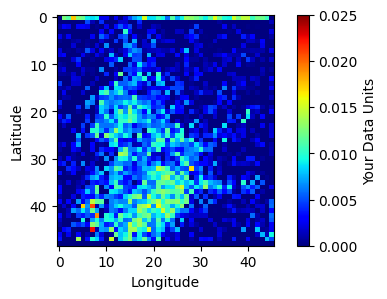

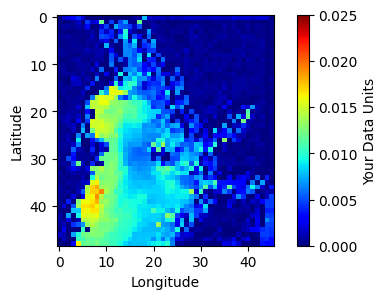

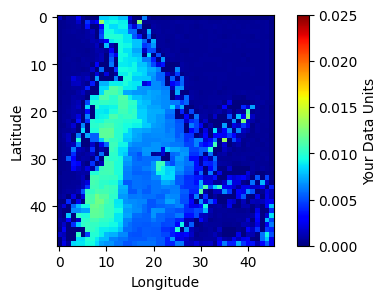

In [7]:
import matplotlib.pyplot as plt
# 遍历每个时间点
for time_index in range(3):
    data = filled_data[0,time_index, :, :]  # 假设数据是3D (time, lat, lon)
    
    plt.figure(figsize=(6, 3))
    plt.imshow(data, cmap='jet', vmin=0, vmax=0.025)
    plt.colorbar(label='Your Data Units')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # 保存图像到本地文件
    # output_file_path = f'G:/YuJinYuan-Experiment/MODIS/interpolation_{time_index}.png'
    # plt.savefig(output_file_path, dpi=600, bbox_inches='tight')
    plt.show()

# 大图绘制

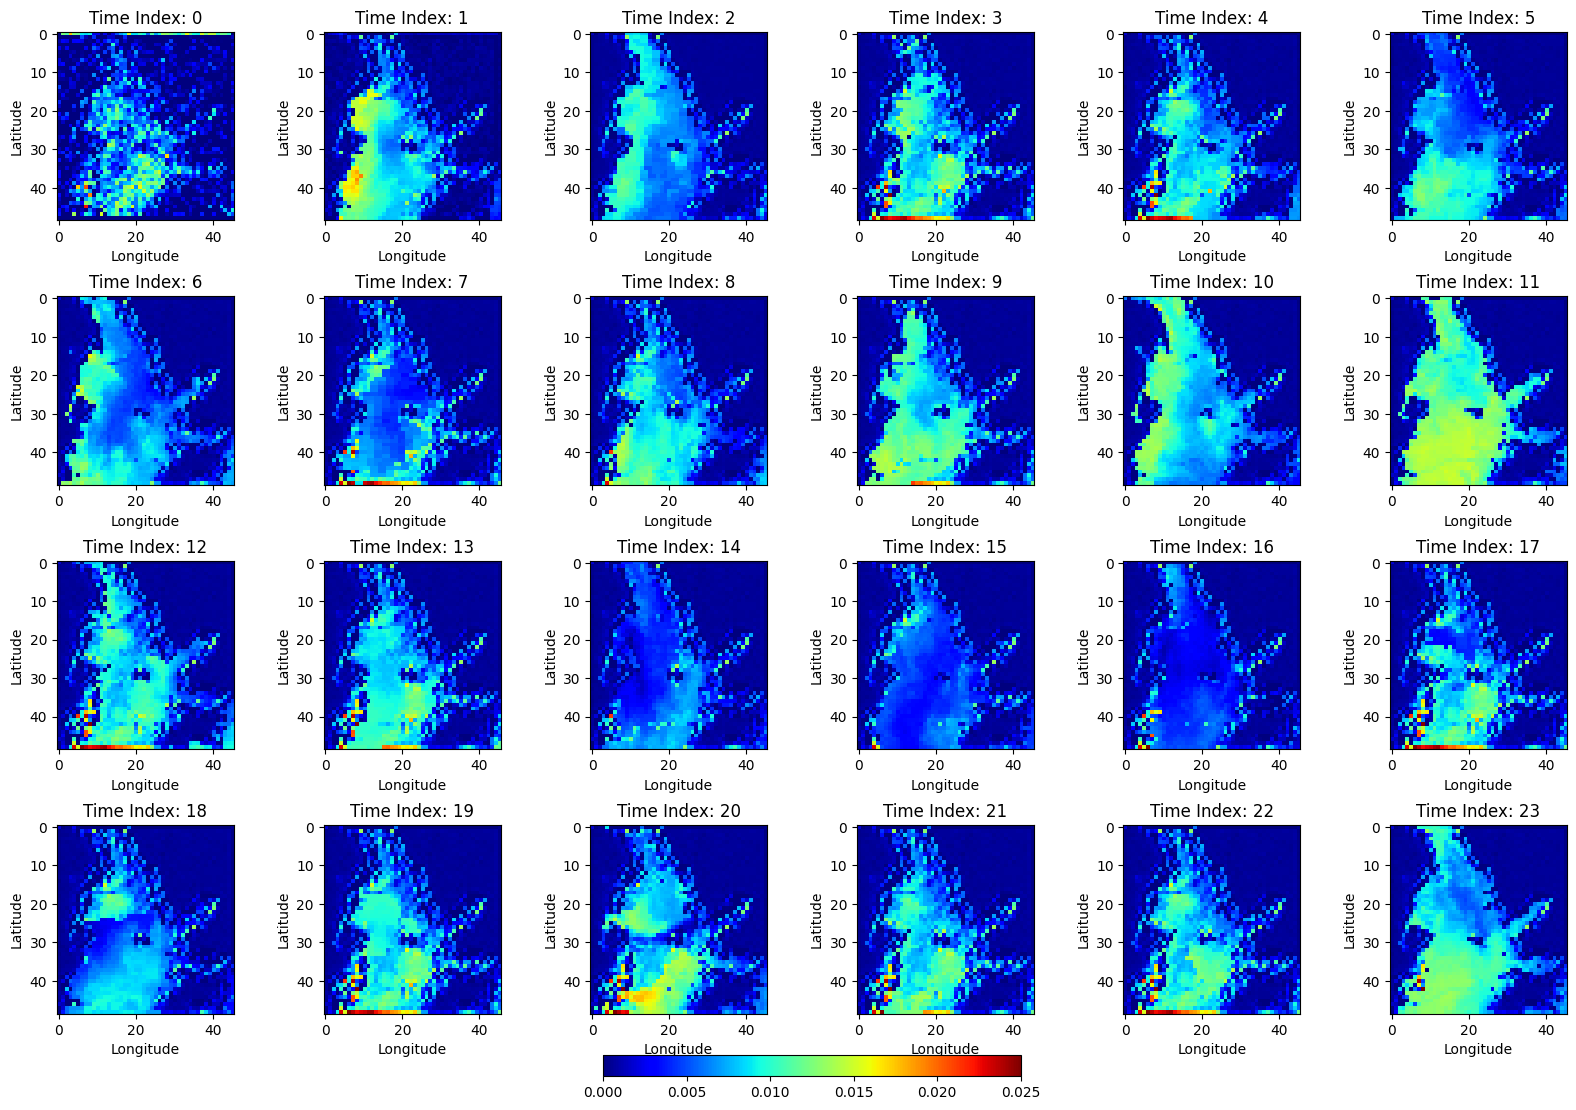

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 filled_data 是一个3D数组，形状为 (time, lat, lon)
# 设置子图的网格大小，例如4行6列
rows = 4  # 根据你的需要调整行数
cols = 6  # 根据你的需要调整列数
num_time_points = rows * cols

# 创建子图
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
# fig.suptitle('Spatio-temporal Interpolation of MODIS Images', fontsize=16)

# 遍历每个时间点并绘制到子图中
for time_index, ax in enumerate(axes.flat):
    if time_index < num_time_points:
        data = filled_data[0, time_index, :, :]  # 获取当前时间点的数据
        im = ax.imshow(data, cmap='jet', vmin=0, vmax=0.025)
        ax.set_title(f'Time Index: {time_index}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    else:
        ax.axis('off')  # 隐藏多余的子图

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0, 0.90, 0.95])

# 添加统一的 colorbar
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.04)
# cbar.set_label('Your Data Units')

# 保存图像到本地文件
output_file_path = 'G:/YuJinYuan-Experiment/MODIS/interpolated_modis_images.png'
plt.savefig(output_file_path, dpi=600, bbox_inches='tight')

# 显示图像
plt.show()


# Flattened绘制

In [ ]:
# 遍历每个时间点
for time_index in range(3):
    data = filled_data[0,time_index, :, :]  # 假设数据是3D (time, lat, lon)
    
    
    # 仅取前100个点，并将其展平成一维
    flat_data = data.flatten()[400:1400]
    
    # 创建一维的正方形格子图
    plt.figure(figsize=(10, 1))  # 设置图形大小，使其为长条状
    plt.imshow(flat_data.reshape(1, 1000), cmap='jet', aspect='auto', vmin=0, vmax=0.025)
    plt.colorbar(label='', orientation='horizontal')
    
    # 移除坐标轴
    plt.axis('off')
    
    # 保存图像到本地文件
    output_file_path = f'G:/YuJinYuan-Experiment/MODIS/flat_filledimage_{time_index}.png'
    plt.savefig(output_file_path, dpi=600, bbox_inches='tight')
    plt.show()

In [ ]:
def test_model_on_file(model, file_path, device):
    # Load test data from the specified .nc file
    dataset = nc.Dataset(file_path, 'r')
    file_name = os.path.basename(file_path)
    prefix = file_name.split('.')[0]
    data_var = dataset.variables[prefix][:]
    mask_var = dataset.variables['mask'][:]
    mask_var = np.expand_dims(mask_var, axis=0)
    missing_value = dataset.variables[prefix]._FillValue

    # Handle missing values
    mask = (mask_var == 1).astype(np.float32)
    # Handle missing values and None entries
    data_var[data_var == missing_value] = 0
    # Replace None values with 0 if data_var has any
    data_var = np.where(data_var == None, 0, data_var)
    data_var[data_var == missing_value] = 0
    # Convert to numpy array and handle NaNs
    data_var = np.nan_to_num(data_var, nan=0.0)


    # Create a DataLoader for the test data
    test_dataset = OceanDataset(
        data_var,
        mask,
        transform=data_transform,
        mask_transform=mask_transform,
        use_random_mask=False
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Run the model on the test data
    model.eval()
    filled_data = []
    with torch.no_grad():
        for data, mask, meta_data in test_loader:
            data = data.to(device)
            meta_data = meta_data.to(device)

            # Forward pass
            outputs = model(data)
            filled_sample = data * meta_data + outputs[:, :, 0, :, :] * (1 - meta_data)
            filled_data.append(filled_sample.cpu().numpy())

    # Concatenate results
    filled_data = np.concatenate(filled_data, axis=0)
    dataset.close()

    return filled_data,data_var
# 加载预训练模型参数
model = ConvLSTM().to(device)
model.load_state_dict(torch.load('ConvLSTM.pth'))
# Example usage
test_file_path = 'G:/YuJinYuan-Experiment/MODIS/test/masked/Rrs_412.nc'
filled_data,data_var = test_model_on_file(model, test_file_path, device)
print(f'Filled data shape: {filled_data.shape}')
